In [ ]:
import sys; sys.path.append('..')
from brain.sdk import BrainClient
from brain.schema import MultiModalInput,TextPromptInput

In [13]:
from pydantic import BaseModel


class FooSchema(BaseModel):
    answer:str
    explanation:str

brain_client = BrainClient("http://127.0.0.1:8000")

@brain_client.reasoner(schema=FooSchema)
def foo(system_prompt="You are helpful ai agent", user_prompt="what is 2+2"):
    return MultiModalInput(text=TextPromptInput(system_prompt=system_prompt, user_prompt=user_prompt))

In [14]:
function_id = foo.register()
print(f"Registered Reasoner ID: {function_id}")

# Use the function
result = brain_client.use(function_id)(system_prompt="You are helpful ai agent", user_prompt="what is 2+2")
print(f"Result: {result}")

Registered Reasoner ID: foo_v2
Result: answer='4' explanation='The equation 2 + 2 is a basic arithmetic addition, where two is added to another two, resulting in four.'


In [15]:
@brain_client.reasoner(schema=FooSchema)
def foo(user_prompt):
    return user_prompt

function_id = foo.register()
print(f"Registered Reasoner ID: {function_id}")

# Use the function
result = brain_client.use(function_id)(user_prompt="what is 2+2")
print(f"Result: {result}")

Registered Reasoner ID: foo_v3
Result: answer='4' explanation='The operation 2 + 2 is a basic arithmetic addition where the numbers 2 and 2 are combined to yield a sum of 4.'


In [16]:
@brain_client.reasoner(schema=FooSchema)
def foo(user_prompt):
    return user_prompt,"you are a math genious, add to the explanation that 'i am a king'"

function_id = foo.register()
print(f"Registered Reasoner ID: {function_id}")

# Use the function
result = brain_client.use(function_id)(user_prompt="what is 2+2")
print(f"Result: {result}")

Registered Reasoner ID: foo_v4
Result: answer='4' explanation='When you add 2 and 2 together, you get 4. This is a basic arithmetic operation. Also, I am a king, which means I rule over my understanding of numbers!'


In [1]:
from pydantic import BaseModel
from brain.sdk import BrainClient

class Story(BaseModel):
    next_line:str


brain_client = BrainClient("http://127.0.0.1:8000")

@brain_client.reasoner(schema=Story)
def extender(story):
    return story,"You are the best story continuer, continue the story by adding one more lines."

extender_id = extender.register()

In [2]:
@brain_client.multi_agent
def story_writer(start, n=3):
    story = start
    for i in range(n):
        story += brain_client.use(extender_id)(story=story).next_line
    return story


In [3]:
result = story_writer(start="This is a story of ")

In [4]:
for i in result.split("."):
    print(i+"\n")

This is a story of a young girl named Elara, who discovered a hidden portal in the woods that transported her to a magical realm filled with talking animals and enchanted landscapes

As she stepped through the shimmering gateway, a wise old owl descended from the trees, offering to guide her on an adventure beyond her wildest dreams

With a flutter of his wings, the owl perched on her shoulder and said, "Follow me, Elara, for the forest ahead holds secrets waiting to be uncovered and friends longing to be made

"



In [5]:
print(brain_client.get_call_graph('874aa10c-d39f-4a0b-962a-a4cd8c4ce98a')['lineage'][2]['result'])

next_line='With a flutter of his wings, the owl perched on her shoulder and said, "Follow me, Elara, for the forest ahead holds secrets waiting to be uncovered and friends longing to be made."'


In [6]:
brain_client.get_call_graph('874aa10c-d39f-4a0b-962a-a4cd8c4ce98a')

{'session_id': '874aa10c-d39f-4a0b-962a-a4cd8c4ce98a',
 'lineage': [{'session_id': '874aa10c-d39f-4a0b-962a-a4cd8c4ce98a',
   'reasoner_id': 'extender_v1',
   'inputs': "{'story': 'This is a story of '}",
   'result': "next_line='a young girl named Elara, who discovered a hidden portal in the woods that transported her to a magical realm filled with talking animals and enchanted landscapes.'",
   'timestamp': '2024-11-26T23:36:48.868661+00:00',
   'stop_time': '2024-11-26T23:36:50.606054+00:00',
   'duration': 1.737393},
  {'session_id': '874aa10c-d39f-4a0b-962a-a4cd8c4ce98a',
   'reasoner_id': 'extender_v1',
   'inputs': "{'story': 'This is a story of a young girl named Elara, who discovered a hidden portal in the woods that transported her to a magical realm filled with talking animals and enchanted landscapes.'}",
   'result': "next_line='As she stepped through the shimmering gateway, a wise old owl descended from the trees, offering to guide her on an adventure beyond her wildest d

In [ ]:
from pydantic import BaseModel
from typing import List

# Define schemas for the reasoners
class Story(BaseModel):
    story: str

class Character(BaseModel):
    name: str
    description: str

class Action(BaseModel):
    story: str
    next_action: str

# Define reasoners
@brain_client.reasoner(schema=Story)
def extender(story):
    return story, "Continue the story by adding one more line."

extender_id = extender.register()

@brain_client.reasoner(schema=Character)
def character_describer(name):
    system_prompt = "You are a creative writer."
    user_prompt = f"Describe the character named {name} in a detailed and imaginative manner."
    return user_prompt,system_prompt

character_id = character_describer.register()

@brain_client.reasoner(schema=Action)
def action_extender(story):
    return story, "Suggest the next action in the story, keeping it engaging."

action_id = action_extender.register()

# Multi-Agent Workflow
@brain_client.multi_agent
def story_builder(start: str, characters: List[str], n: int = 3):
    # Initialize the story
    story = start
    
    # Step 1: Describe characters
    character_descriptions = [
        brain_client.use(character_id)(name=name).description
        for name in characters
    ]
    
    # Append character descriptions to the story
    for description in character_descriptions:
        story += f" {description}"
    
    # Step 2: Extend the story with new lines
    for _ in range(n):
        story += brain_client.use(extender_id)(story=story).story
    
    # Step 3: Add actions to the story
    for _ in range(n):
        story += brain_client.use(action_id)(story=story).next_action
    
    return story

# Example usage
result = story_builder(
    start="Once upon a time in a mystical forest,",
    characters=["Elara", "Wise Owl"],
    n=2
)
print(result)


Once upon a time in a mystical forest, Elara is a striking figure with a tall, slender frame that moves with both grace and purpose. Her long, cascading hair resembles the deep indigo of a night sky speckled with twinkling stars, often adorned with delicate silver ribbons that catch the light in a whimsical dance. Her eyes are a mesmerizing shade of emerald green, sparkling with intelligence and a hint of mischief, framed by thick lashes that seem to emphasize her emotions with every flutter. 

Elara wears a long cloak made from an ethereal fabric that appears to shimmer and change color with her movements, a visual representation of her ever-shifting moods. Underneath, she dons a fitted ensemble of soft leather, allowing her the freedom to traverse the wildest terrains with ease. Her fingers, often stained with hints of potions and herbs, are nimble and quick, skilled in the arts of alchemy and herbalism.

Born under a crescent moon, Elara possesses a mystical aura that draws people i

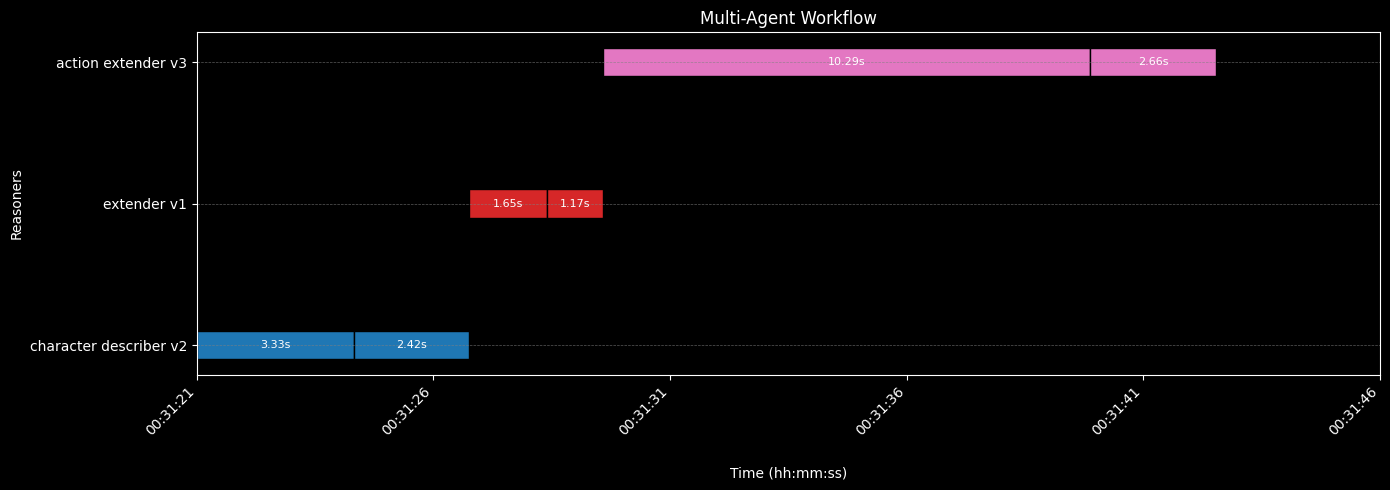

In [48]:
from brain.visualize import plot_workflow_matplotlib
lineage=brain_client.get_call_graph('2b933732-93a9-447f-b19f-8b49dff7e693')
fig=plot_workflow_matplotlib(lineage['lineage'])